<a href="https://colab.research.google.com/github/audricc/covid19/blob/master/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# PACKAGES

import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import pylab
from scipy.optimize import curve_fit

%matplotlib inline
pl.style.use('ggplot')
%config InlineBackend.figure_format = 'png2x'
pylab.rcParams['figure.figsize'] = 12, 8

In [11]:
# PULL JOHN HOPKINS DATA

ds_start = dt.datetime(2020,1,22)
ds_end = dt.datetime.today()
ds_list = [(ds_start + dt.timedelta(k)) for k in range((ds_end - ds_start).days)]

data = pd.DataFrame()
for ds in ds_list:
  ds_string = ds.strftime('%m-%d-%Y')
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{ds_string}.csv'.format(**locals())
  data_ds = pd.read_csv(url)
  data_ds['ds'] = ds
  data = data.append(data_ds, sort=True)

# CALIFORNIA

data_ca_raw = data[((data['Country_Region'] == 'US') & (data['Province_State'] == 'California') & (data['ds'] >= dt.datetime(2020,3,1))) |
               ((data['Country/Region'] == 'US') & (data['Province/State'] == 'California') & (data['ds'] >= dt.datetime(2020,3,1))) ]
data_ca = data_ca_raw.groupby('ds', as_index=False).sum() # sum across counties
data_ca['Confirmed_new'] = data_ca['Confirmed'].diff()
data_ca['Deaths_new'] = data_ca['Deaths'].diff()

# SF BAY AREA

data_bay_raw = data[(data['Country_Region'] == 'US') & 
                    ((data['Admin2'] == 'Contra Costa') |
                     (data['Admin2'] == 'Alameda') |
                     (data['Admin2'] == 'San Mateo') |
                     (data['Admin2'] == 'Santa Clara') |
                     (data['Admin2'] == 'Marin') |
                     (data['Admin2'] == 'Solano') |
                     (data['Admin2'] == 'Sonoma') |
                     (data['Admin2'] == 'San Francisco') |
                     (data['Admin2'] == 'Napa')
                    )]
data_bay = data_bay_raw.groupby('ds', as_index=False).sum() # sum across counties
data_bay['Confirmed_new'] = data_bay['Confirmed'].diff()
data_bay['Deaths_new'] = data_bay['Deaths'].diff()

# SAN FRANCISCO

data_sf_raw = data[(data['Country_Region'] == 'US') & (data['Admin2'] == 'San Francisco')]
data_sf = data_sf_raw.groupby('ds', as_index=False).sum() 
data_sf['Confirmed_new'] = data_sf['Confirmed'].diff()
data_sf['Deaths_new'] = data_sf['Deaths'].diff()
data_sf.tail()

,ds,Active,Confirmed,Deaths,FIPS,Lat,Latitude,Long_,Longitude,Recovered,Confirmed_new,Deaths_new
2,2020-03-24,0.0,152.0,0.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,21.0,0.0
3,2020-03-25,0.0,178.0,1.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,26.0,1.0
4,2020-03-26,0.0,223.0,2.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,45.0,1.0
5,2020-03-27,0.0,279.0,3.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,56.0,1.0
6,2020-03-28,0.0,308.0,4.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,29.0,1.0


[-2.15169611e-03  1.20491934e+02  9.02649602e+00]


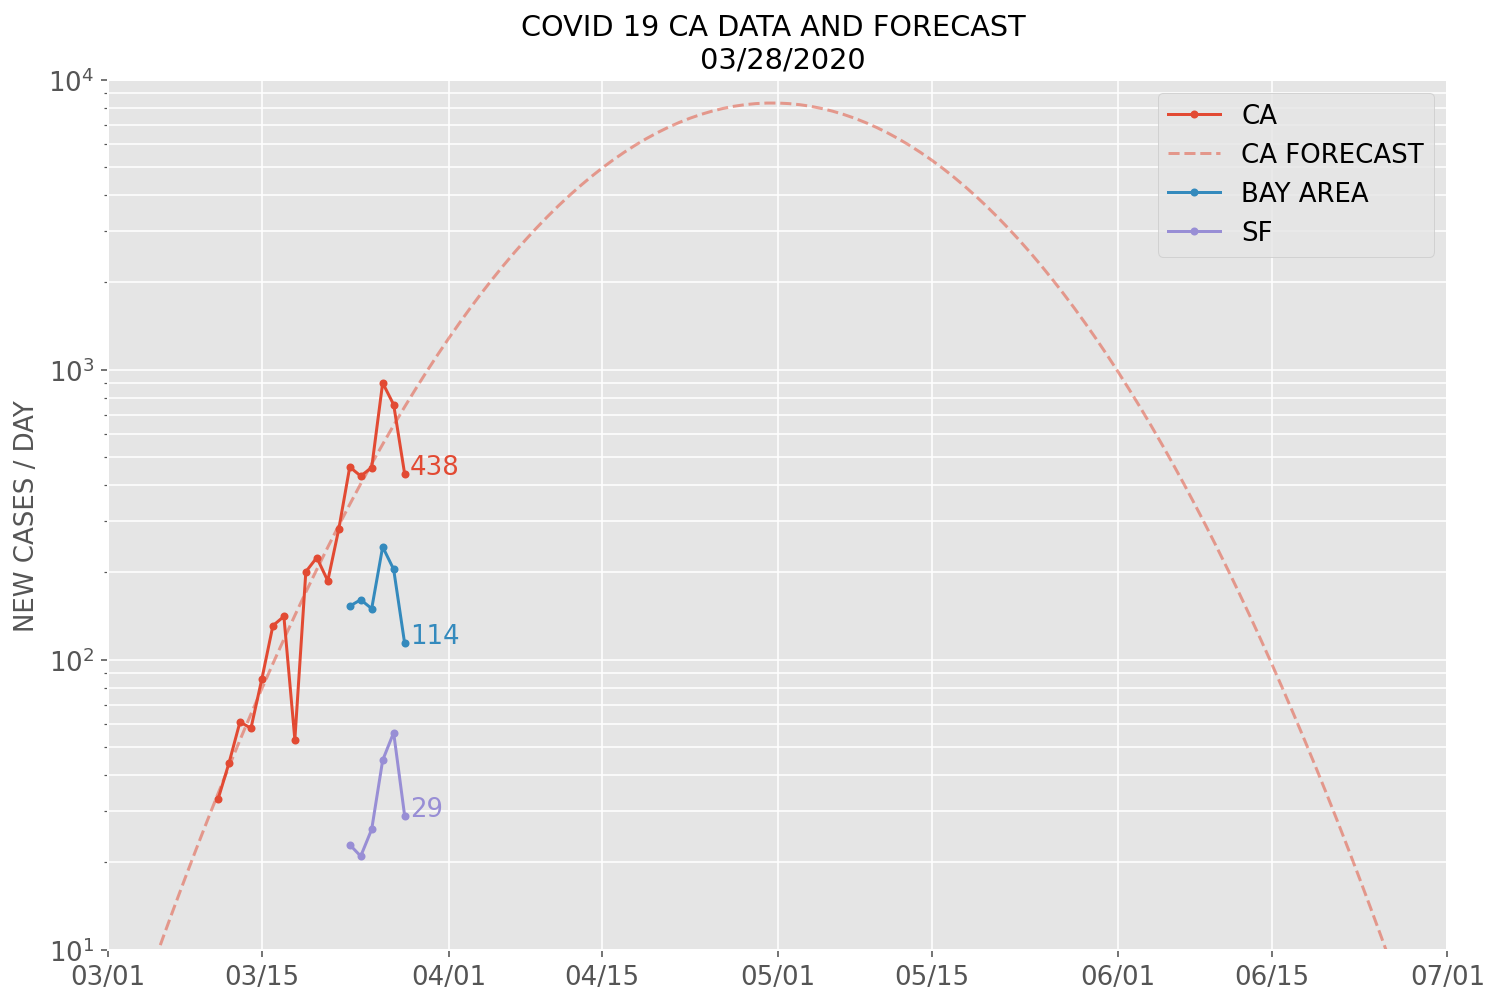

In [19]:
# CALIFORNIA FORECAST: CONFIRMED NEW

# forecast
data_ca_copy = data_ca.dropna()
ds_data = data_ca_copy.ds
x_data = [(ds - dt.datetime(2020,1,1)).days for ds in data_ca_copy.ds]
y_data = np.log(data_ca_copy.Confirmed_new)

f = lambda x, a, b, c:a*(x-b)**2 + c
p = curve_fit(f, x_data, y_data)[0]
print(p)

x_forecast = np.arange(0,365)
ds_forecast = [dt.datetime(2020,1,1) + dt.timedelta(int(k)) for k in x_forecast]
y_forecast = [f(x, p[0], p[1], p[2]) for x in x_forecast]

# plots
ax1 = pl.plot(data_ca.ds, data_ca.Confirmed_new, marker='.', label='CA')
pl.plot(ds_forecast, np.exp(y_forecast), c=ax1[0].get_color(), ls='--', alpha=0.5, label='CA FORECAST')
pl.text(data_ca.ds.iloc[-1]+dt.timedelta(0.5), data_ca.Confirmed_new.iloc[-1], s=int(data_ca.Confirmed_new.iloc[-1]), c=ax1[0].get_color(), fontsize=13)

ax2 = pl.plot(data_bay.ds, data_bay.Confirmed_new, marker='.',  label='BAY AREA')
pl.text(data_bay.ds.iloc[-1]+dt.timedelta(0.5), data_bay.Confirmed_new.iloc[-1], s=int(data_bay.Confirmed_new.iloc[-1]), c=ax2[0].get_color(), fontsize=13)

ax3 = pl.plot(data_sf.ds, data_sf.Confirmed_new, marker='.',  label='SF')
pl.text(data_sf.ds.iloc[-1]+dt.timedelta(0.5), data_sf.Confirmed_new.iloc[-1], s=int(data_sf.Confirmed_new.iloc[-1]), c=ax3[0].get_color(), fontsize=13)

# formatting
fmt = mdates.DateFormatter("%m/%d")
ax = pl.gca()
ax.xaxis.set_major_formatter(fmt)

pl.title('COVID 19 CA DATA AND FORECAST \n {0}'.format(data_ca.ds.iloc[-1].strftime('%m/%d/%Y')))
pl.xlim(dt.datetime(2020,3,1), dt.datetime(2020,7,1))
pl.ylim(10, 1e4)
pl.yscale('log')
pl.ylabel('NEW CASES / DAY', fontsize=13)
pl.legend(fontsize=13)
pl.xticks(fontsize=13)
pl.yticks(fontsize=13)
pl.grid(True,which="both",ls="-")



[ 4.70190028e-03  5.77680520e+01 -9.21722163e-01]


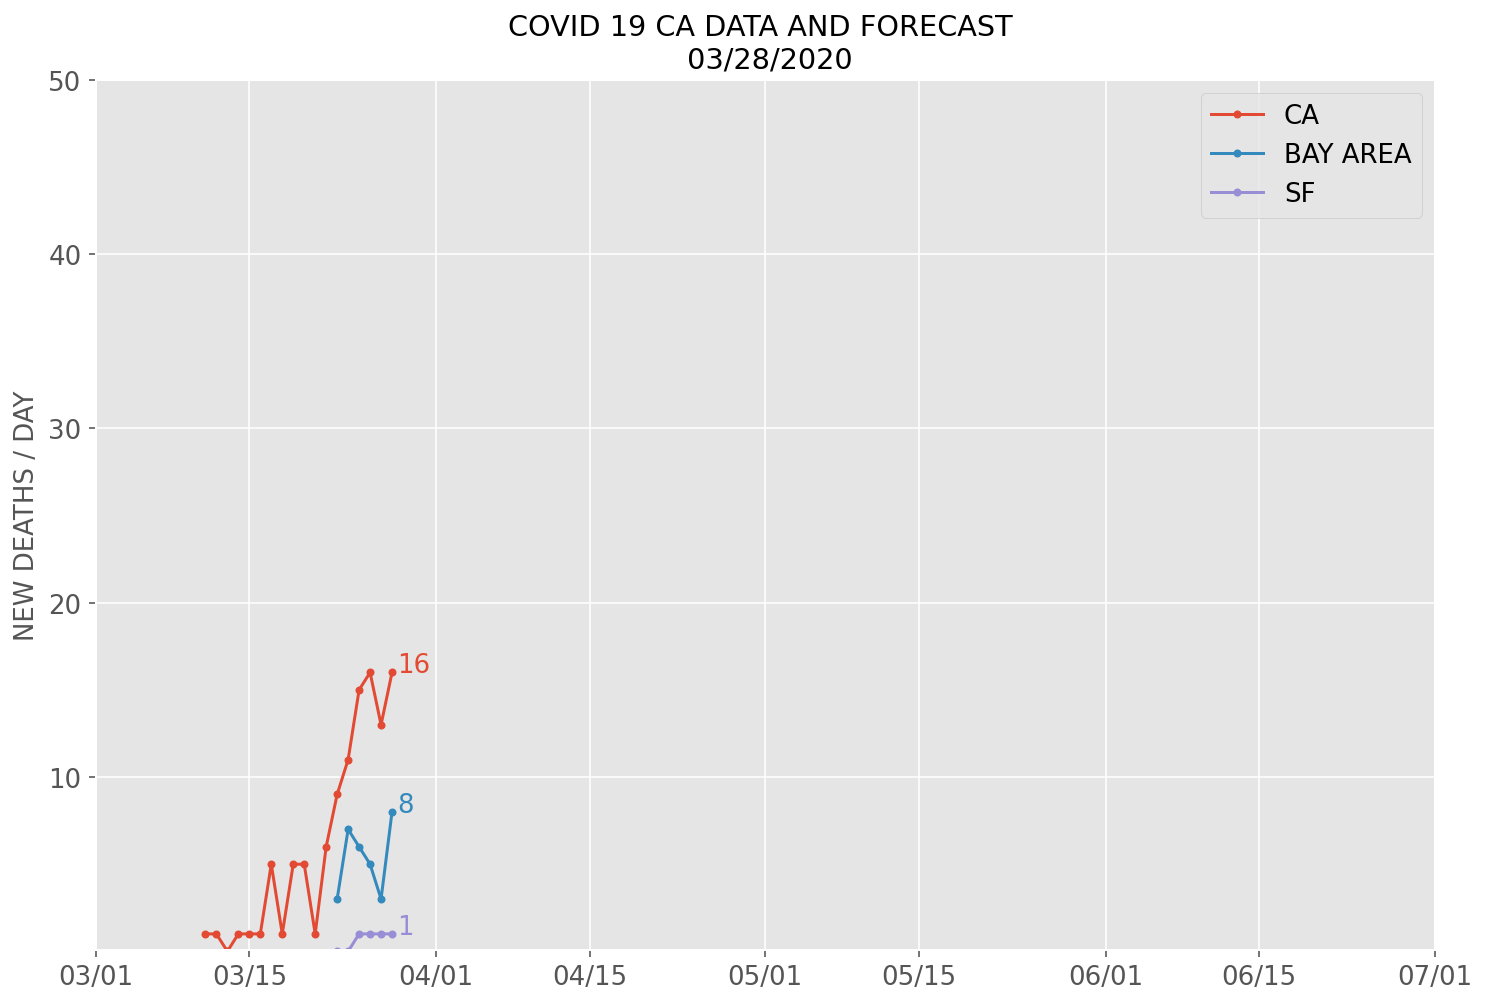

In [31]:
# CALIFORNIA FORECAST: DEATHS NEW

# forecast
data_ca_copy = data_ca.replace(to_replace={'Deaths_new':0.}, value=np.nan)
data_ca_copy = data_ca_copy.dropna() # remove nan and zeros
ds_data = data_ca_copy.ds
x_data = [(ds - dt.datetime(2020,1,1)).days for ds in data_ca_copy.ds]
y_data = np.log(data_ca_copy.Deaths_new)

f = lambda x, a, b, c:a*(x-b)**2 + c
p = curve_fit(f, x_data, y_data)[0]
print(p)

x_forecast = np.arange(0,365)
ds_forecast = [dt.datetime(2020,1,1) + dt.timedelta(int(k)) for k in x_forecast]
y_forecast = [f(x, p[0], p[1], p[2]) for x in x_forecast]

# plots
ax1 = pl.plot(data_ca.ds, data_ca.Deaths_new, marker='.', label='CA')
# pl.plot(ds_forecast, np.exp(y_forecast), c=ax1[0].get_color(), ls='--', alpha=0.5, label='CA FORECAST')
pl.text(data_ca.ds.iloc[-1]+dt.timedelta(0.5), data_ca.Deaths_new.iloc[-1], s=int(data_ca.Deaths_new.iloc[-1]), c=ax1[0].get_color(), fontsize=13)

ax2 = pl.plot(data_bay.ds, data_bay.Deaths_new, marker='.',  label='BAY AREA')
pl.text(data_bay.ds.iloc[-1]+dt.timedelta(0.5), data_bay.Deaths_new.iloc[-1], s=int(data_bay.Deaths_new.iloc[-1]), c=ax2[0].get_color(), fontsize=13)

ax3 = pl.plot(data_sf.ds, data_sf.Deaths_new, marker='.',  label='SF')
pl.text(data_sf.ds.iloc[-1]+dt.timedelta(0.5), data_sf.Deaths_new.iloc[-1], s=int(data_sf.Deaths_new.iloc[-1]), c=ax3[0].get_color(), fontsize=13)

# formatting
fmt = mdates.DateFormatter("%m/%d")
ax = pl.gca()
ax.xaxis.set_major_formatter(fmt)

pl.title('COVID 19 CA DATA AND FORECAST \n {0}'.format(data_ca.ds.iloc[-1].strftime('%m/%d/%Y')))
pl.xlim(dt.datetime(2020,3,1), dt.datetime(2020,7,1))
pl.ylim(1e-1, 50)
# pl.yscale('log')
pl.ylabel('NEW DEATHS / DAY', fontsize=13)
pl.legend(fontsize=13)
pl.xticks(fontsize=13)
pl.yticks(fontsize=13)
pl.grid(True,which="both",ls="-")



NOTES: Deaths data is still too noisy to get reasonable forecast.